Clasificadores:En el caso de los algoritmos de clasificacion, podemos  decir que un clasificador es un algoritmo que, recibiendo como entrada cierta información de un objeto, es capaz indicar la categoría o clase a que pertenece de entre un número acotado de clases posibles.

Es decir lo que distinge los clasificadores de una regresión es que la variable objetivo se trata de un estado, concepto, categoria... Es decir un clasificador puede entrenarse para decir si algo pertenece a una categoria, para saber si hace frio o calor en una sala, decir si alguien es alto bajo... (conceptos abstractos)

# Clasificación de iconos con MLP (MultiLayer Perceptron Classifier)

Libreria necesarias a importar y comprobación de disponibilidad de torch en nuestro dispositivo.

In [21]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


## Creación de los cargadores de datos.

1º Linea: Se define un tamaño de 30 datos de entrada al entrenar por iteración que forma el lote.

2º Linea: Se prepara la funcion trasnform para la normalizacion de los datos, es decir se extienden los datos dentro de un rango haciendo uso de la media y la desviación estandar de los datos de entrenamiento con el fin de mejorar el rendimiento de la red.

3º Linea:Se obtiene el conjunto de datos que forman el dataset de entrenamiento sin alterar, obtenido de CIFAR10 aqui se aplica la normalización.

4º Linea:Se obtiene el conjunto de datos que forman el conjunto de validación, estos datos no se alteran por esos su parametro train esta a falso, ya que este conjunto nos servirá para comprobar la predicciones hechas por la red.

5º Linea:Se crea los datos de entrenamiento separado por lotes además a estos se les aplican una función shuffle que cambia de forma aleatoria la posición de estos dentro del conjunto (Esto sirve para que la red no se acomode a unos datos fijos y haga su predicción en base a la invariabilidad que no representan mundo real donde los eventos son cambiantes y desconocidos)

6º Linea:Se obtiene el conjunto de datos que forman el conjunto de validación del cargador, estos datos no se alteran por esos su parametro train esta a falso, ya que este conjunto nos servirá para comprobar la predicciones hechas por la red.

In [22]:
batch_size = 30

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                ])

train_dataset = datasets.CIFAR10('/tmp/data', 
                               train=True, 
                               download=True, 
                               transform=transforms)

validation_dataset = datasets.CIFAR10('/tmp/data', 
                                    train=False, 
                                    transform=transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

Files already downloaded and verified


The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 3, 32, 32), i.e. it consists of a batch of images of size 3x32x32 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training icon.

In [23]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([30, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([30]) type: torch.LongTensor


Mostramos los 10 primeros dígitos:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

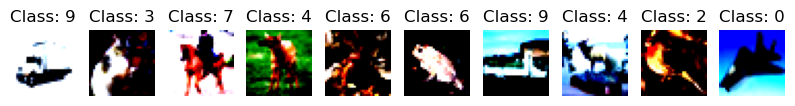

In [24]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i,:,:,:].numpy(), (1,2,0)))
    plt.title('Class: '+str(y_train[i].item()))

## Definición del modelo MLP.

Este modelo tiene 3 capas, 2 de ellas con 50 neuronas y 1 con 10.
Función de activación ReLU después de las 2 primeras capas y softmax a la útlima.



Definicion del modelo:
def _init_self: Se definen las capas de que componen la red, en este caso se tiene:
 
 DatosEntrada -> Capa1(3*32*32, 50) -> Capa2(50, 50) -> Capa3(50, 10)  -> Resultado de la red 
 (Se utiliza la función Linear ya que se trantan de capas intermedias.)
 
 def forward(self, x): Primero se pasa la matriz a vector ya que la red necesita los datos de netrada en forma de     vector, lo siguiente es ir bajando desde la capa1 hasta la 3 aplicando la funcion de activacion correspondiente,     en este caso relu, esta función puede ser aplicada en todas las capas ya que no trabaja con pesos.
  por ultimo se retorna el resultado final de la red.

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 3*32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


## Creación del modelo, optimizador y función de pérdida.


1º Linea:Se define la red define la red.
2º Se elige el optimizador, en este caso SGD cuyos parámetros son los parametros del modelo y el learning rate.

El optimizador, es el encargado de generar pesos cada vez mejores: su importancia es crucial. Su funcionamiento esencial se basa en calcular el gradiente de la función de coste (derivada parcial) por cada peso (parametro/dimension) de la red. 

3º Se escoje el criterio de calculo de error, en este caso escoje CrossEntropyLoss es una función que penaliza solo las predicciones correctas, por lo que la función de perdidas (lo que llamos en clase error) solo es calculada para las predicciones correctas.

In [26]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


## Learning

Definición del método de entrenamiento `train()` y del método de validación `validate()`. 

Se inicia el proceso de entrenamiento poniendo el modelo en modo entrenamiento.

Se tiene un bucle que itera sobre los datos del lote, y se repite el siguiente proceso:

1º Se obtienen los datos.
2º Se limpia el gradiente para el entrenamiento.
3º Se pasan los datos de entrada por la red.
4º Se obtiene un vector de datos objetivo a partir de la matriz de datos original.
5º Se calcula el error de entrenamiento en funcion de los datos objetivo y la salida generada por lal red.
6º Se propagan los datos desde las capas mas profundas de la red hasta la primera, actualizando la "influencia" relativa de cada neurona sobre el resultado final a partir de los errores relativos(Linea 5) calculados tras la primera pasada de los datos iniciales por la red.
7º Se actualizan los pesos.


In [27]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

Se obtiene el error de entrenamiento medio para tener una visión general del rendimiento de la red (solo de aquellas predicciones correctas)

In [28]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


# Bucle de entrenamiento

Por cada epoch, vamos a entrenar y después a validar el modelo

In [ ]:
Método principal donde todo el proceso de entrenamiento se da lugar (donde se llaman a los métodos anteriormente descritos)

Se hace un bucle que itera por cada lote del dataset (data_loader) y se hacen los siguientes pasos:
1º Se entrena los datos.
2º Se valida el resultado.


In [29]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.282331
Train Epoch: 1 [6000/50000 (12%)]	Loss: 2.051558
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.817772
Train Epoch: 1 [18000/50000 (36%)]	Loss: 1.509398
Train Epoch: 1 [24000/50000 (48%)]	Loss: 2.077801
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.377693
Train Epoch: 1 [36000/50000 (72%)]	Loss: 1.743231
Train Epoch: 1 [42000/50000 (84%)]	Loss: 1.680351
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.923007

Validation set: Average loss: 1.5706, Accuracy: 4411/10000 (44%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.601473
Train Epoch: 2 [6000/50000 (12%)]	Loss: 1.552677
Train Epoch: 2 [12000/50000 (24%)]	Loss: 1.393746
Train Epoch: 2 [18000/50000 (36%)]	Loss: 1.392221
Train Epoch: 2 [24000/50000 (48%)]	Loss: 1.491000
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.421096
Train Epoch: 2 [36000/50000 (72%)]	Loss: 1.159648
Train Epoch: 2 [42000/50000 (84%)]	Loss: 1.457631
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.396390

Validation set: Average loss: 1.5061, Accura

Visualización del proceso de entrenamiento

* *Loss* diferencia entre la salida del modelo y la real.  Hay que minimizarla hasta 0, para ello usamos el optimizador.
* *Accuracy* es la precisión del modelo.

Se crea dos gráficas:

1º Es una gráfica que expone los errores de validacion a lo largo de las iteraciones(segun avanza la predición por lotes), es decir se muestra el progreso de la red a la hora de clasificar un objeto, a medida que esta progresa por los lotes su exito al clasificacion parece mejorar.

2º En la segunda gráfica se expone la tasa de acierto que ha tenido la red una vez ha clasificado correctamente el objeto, es decir se puede ver como de bien ha distinguido que ese dato, se corresponde con esa etiqueta.

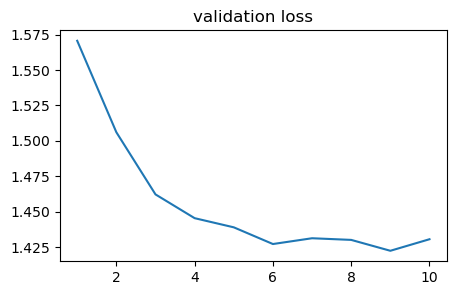

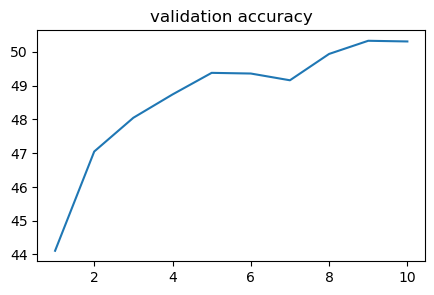

In [30]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');